In [2]:
# Instalasi library yang dibutuhkan
!pip install sastrawi pandas scikit-learn seaborn matplotlib joblib

# Impor semua library yang akan digunakan
import pandas as pd
import numpy as np
import os
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# Impor untuk Preprocessing
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

print("Library siap digunakan.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.2 MB/s eta 0:00:00
Library siap digunakan.


# Load Data

In [3]:
!git clone https://github.com/Ricco48/Emotion-Dataset-from-Indonesian-Public-Opinion.git

Cloning into 'Emotion-Dataset-from-Indonesian-Public-Opinion'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 67 (delta 24), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (67/67), 321.62 KiB | 6.18 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [4]:
base_dir = "Emotion-Dataset-from-Indonesian-Public-Opinion/Emotion Dataset from Indonesian Public Opinion"

file_to_emotion = {
    "NeutralData.csv": "neutral",
    "AngerData.csv": "anger",
    "JoyData.csv": "joy",
    "FearData.csv": "fear",
    "LoveData.csv": "love",
    "SadData.csv": "sad"
}

dfs = []

for file_name, emotion_label in file_to_emotion.items():
    file_path = os.path.join(base_dir, file_name)
    if os.path.exists(file_path):
        df_temp = pd.read_csv(file_path, sep='\t')
        df_temp['emotion'] = emotion_label
        dfs.append(df_temp)
    else:
        print(f"File {file_path} tidak ditemukan!")

df = pd.concat(dfs, ignore_index=True)

print("Data gabungan:")
print(df.head())

print("\nDistribusi emosi:")
print(df['emotion'].value_counts())

Data gabungan:
                                               Tweet    Label  emotion
0    pengabdian yang terpuji meskipun terlihat biasa  Neutral  neutral
1                            baru saja mengirim foto  Neutral  neutral
2  apa kabar dunia twitter ? masihkah selucu dan ...  Neutral  neutral
3  yah gimana sih yang yaudah susul aku dulu kita...  Neutral  neutral
4                saja ka dorg suro beli medium 2 set  Neutral  neutral

Distribusi emosi:
emotion
neutral    2001
joy        1275
anger      1130
sad        1003
fear        911
love        760
Name: count, dtype: int64


# Exploratory Data Analysis

## Basic

In [5]:
# 1. Informasi tipe data dan missing value
print(df.info())

# 2. Statistik ringkas
print(df.describe())

# 3. Distribusi label emosi
print(df['emotion'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7080 entries, 0 to 7079
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Tweet    7080 non-null   object
 1   Label    7080 non-null   object
 2   emotion  7080 non-null   object
dtypes: object(3)
memory usage: 166.1+ KB
None
        Tweet    Label  emotion
count    7080     7080     7080
unique   7018        6        6
top     sedih  Neutral  neutral
freq        5     2001     2001
emotion
neutral    2001
joy        1275
anger      1130
sad        1003
fear        911
love        760
Name: count, dtype: int64


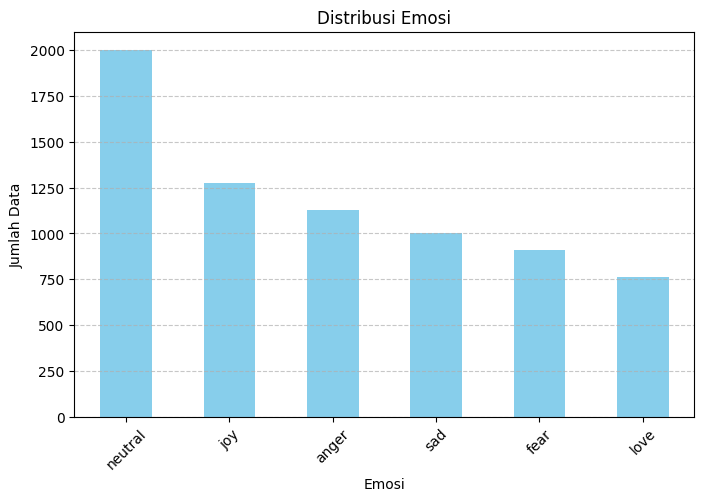

In [6]:
# 4. Visualisasi distribusi label
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
df['emotion'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribusi Emosi')
plt.xlabel('Emosi')
plt.ylabel('Jumlah Data')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [7]:
# 5. Panjang teks per emosi (untuk cek variasi panjang teks)
df['text_length'] = df['Tweet'].apply(len)
print(df.groupby('emotion')['text_length'].describe())

          count        mean        std   min   25%    50%    75%     max
emotion                                                                 
anger    1130.0  102.993805  83.113723   5.0  40.0   75.0  150.0   882.0
fear      911.0   73.635565  62.349414   4.0  29.0   53.0   96.0   280.0
joy      1275.0   79.969412  69.234012   5.0  29.0   55.0  111.0   299.0
love      760.0  128.086842  79.257392  11.0  64.0  109.5  190.5   303.0
neutral  2001.0  112.696652  80.499972   4.0  46.0   92.0  166.0   507.0
sad      1003.0   95.930209  99.674856   4.0  34.5   68.0  128.0  2097.0


## Deep

<ipython-input-8-efa86f6ae2f3>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='emotion', y='text_length', palette='Set2')


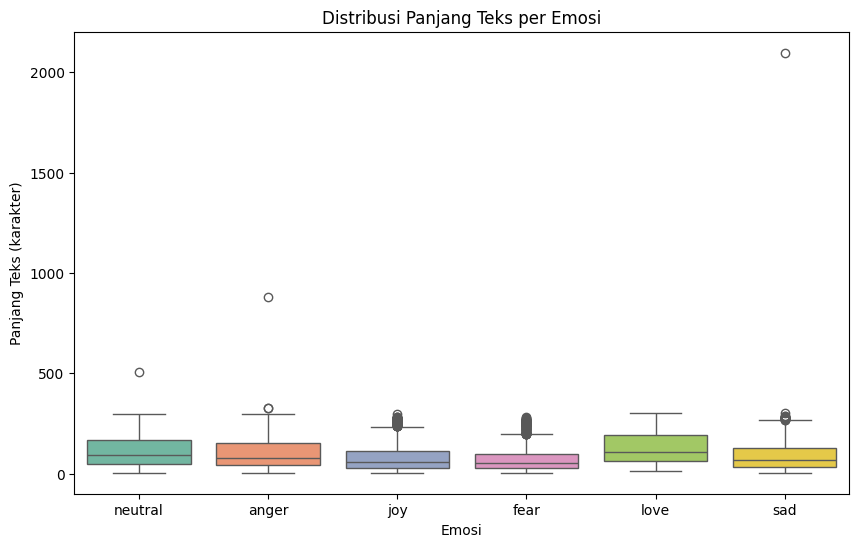

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# 1. Visualisasi distribusi panjang teks per emosi pakai boxplot
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='emotion', y='text_length', palette='Set2')
plt.title('Distribusi Panjang Teks per Emosi')
plt.xlabel('Emosi')
plt.ylabel('Panjang Teks (karakter)')
plt.show()

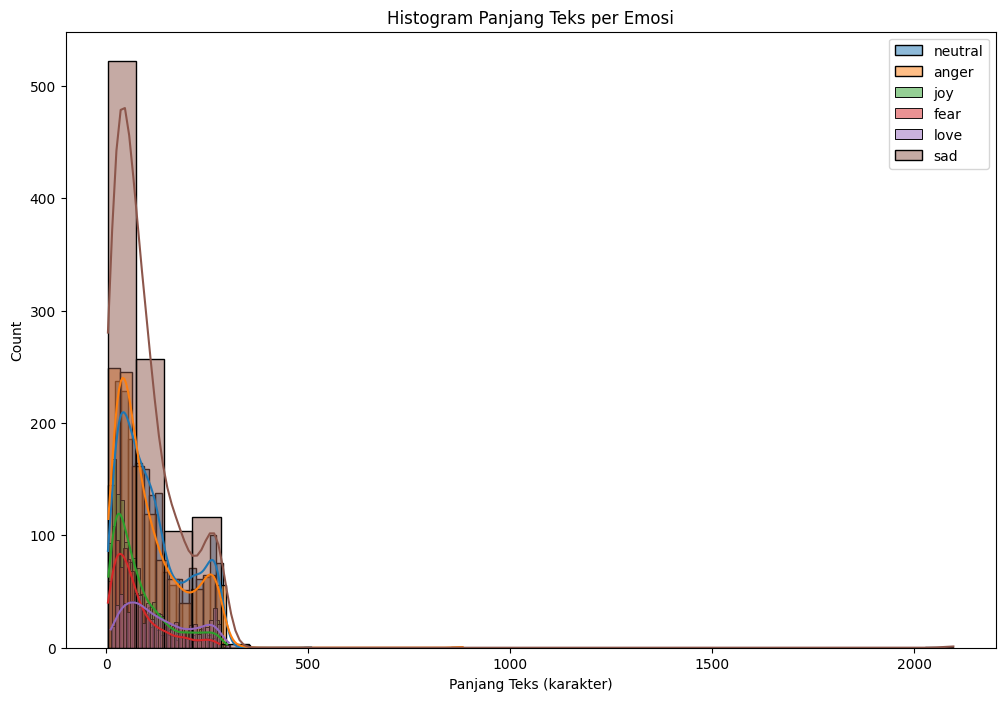

In [9]:
# 2. Histogram panjang teks per emosi
plt.figure(figsize=(12,8))
for emotion in df['emotion'].unique():
    subset = df[df['emotion'] == emotion]
    sns.histplot(subset['text_length'], label=emotion, kde=True, bins=30, alpha=0.5)
plt.title('Histogram Panjang Teks per Emosi')
plt.xlabel('Panjang Teks (karakter)')
plt.legend()
plt.show()

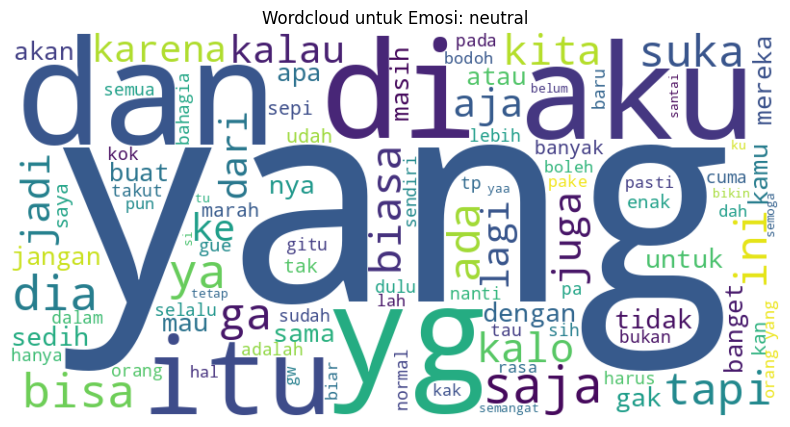

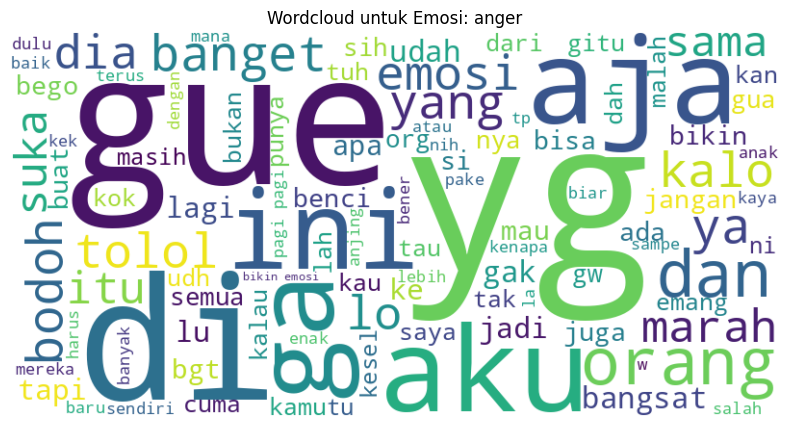

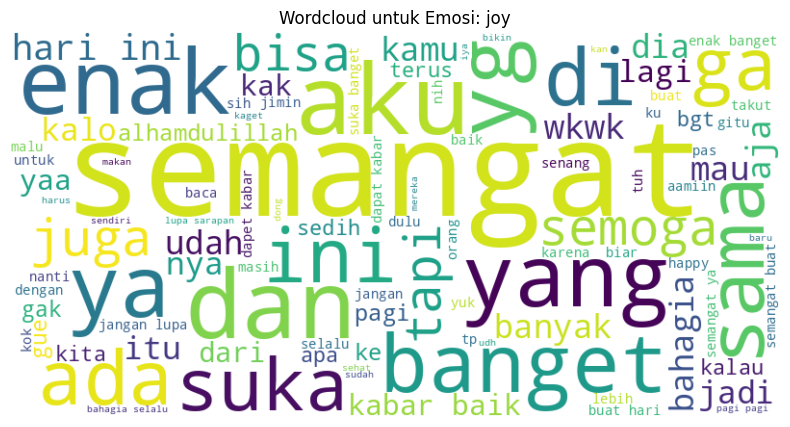

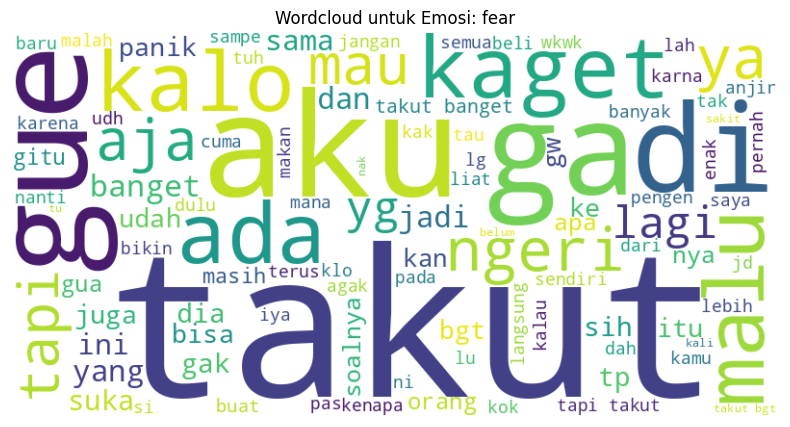

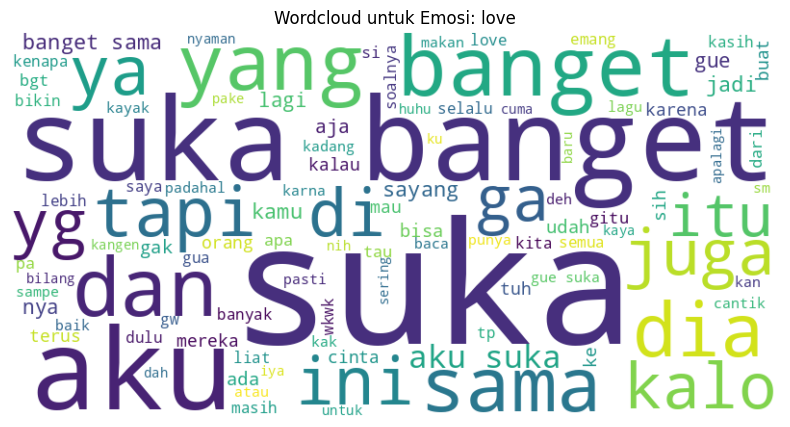

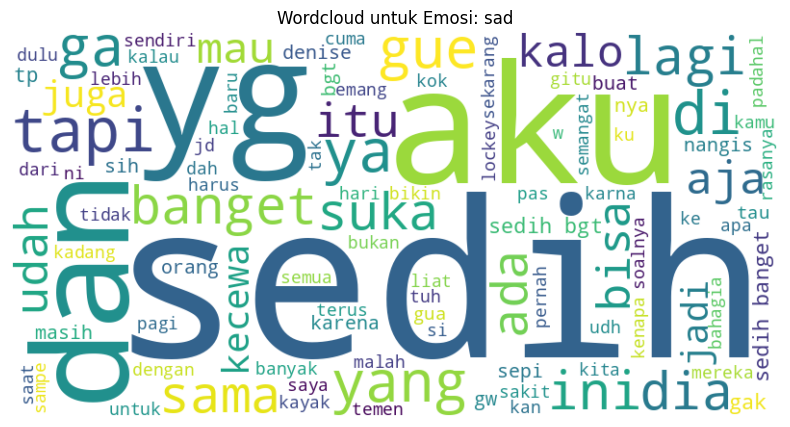

In [10]:
# 3. Wordcloud kata-kata paling sering muncul per emosi
stopwords = set(STOPWORDS)
for emotion in df['emotion'].unique():
    text = ' '.join(df[df['emotion'] == emotion]['Tweet'].values).lower()
    wc = WordCloud(stopwords=stopwords, background_color='white', max_words=100, width=800, height=400)
    wc.generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Wordcloud untuk Emosi: {emotion}')
    plt.show()

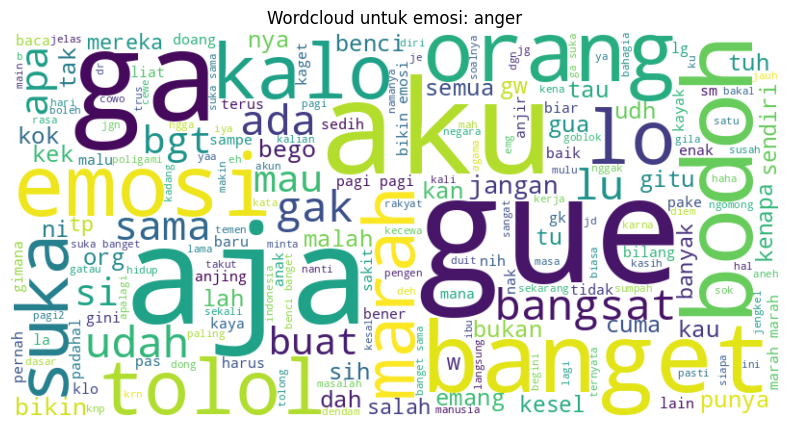

In [11]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Stopwords Bahasa Indonesia (bisa ditambah sesuai kebutuhan)
stopwords_id = set([
    'yang', 'di', 'ke', 'dari', 'dan', 'atau', 'ini', 'itu', 'untuk', 'dengan',
    'pada', 'adalah', 'saya', 'kamu', 'dia', 'kami', 'kita', 'akan', 'sebagai',
    'juga', 'oleh', 'karena', 'tapi', 'jadi', 'dalam', 'agar', 'lebih', 'dulu',
    'sudah', 'belum', 'kalau', 'supaya', 'saat', 'sehingga', 'tetapi', 'hanya',
    'lagi', 'masih', 'bisa', 'saja', 'pun', 'dan lain-lain', 'dll', 'yg', 'loh', 'ya'
])

# Fungsi untuk gabungkan semua teks dari satu emosi, hapus stopwords, dan bikin wordcloud
def plot_wordcloud_emotion(df, emotion_label):
    text = " ".join(df[df['emotion'] == emotion_label]['Tweet'].tolist()).lower()
    # Hapus stopwords
    filtered_words = " ".join([word for word in text.split() if word not in stopwords_id])

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_words)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Wordcloud untuk emosi: {emotion_label}')
    plt.show()

# Pemanggilan fungsi buat emosi 'anger'
plot_wordcloud_emotion(df, 'anger')

In [12]:
# Inisialisasi Stemmer dan Stopword Remover (hanya sekali)
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

stopword_factory = StopWordRemoverFactory()
stopword_remover = stopword_factory.create_stop_word_remover()

# Fungsi Preprocessing Standar dan Final
def preprocess_text_final(text):
    # 1. Case Folding
    text = text.lower()
    # 2. Hapus Tanda Baca
    text = text.translate(str.maketrans('', '', string.punctuation))
    # 3. Hapus Angka
    text = re.sub(r'\d+', '', text)
    # 4. Hapus Whitespace berlebih
    text = text.strip()
    # 5. Stopword Removal
    text = stopword_remover.remove(text)
    # 6. Stemming
    text = stemmer.stem(text)
    return text

print("Fungsi preprocessing siap.")

Fungsi preprocessing siap.


In [13]:
# Terapkan fungsi ke seluruh kolom teks
# Gunakan 'text_original' sesuai nama kolom dari SEL 2
print("Memulai proses preprocessing... Ini mungkin memakan waktu beberapa saat.")
df['text_processed'] = df['Tweet'].apply(preprocess_text_final)
print("Preprocessing selesai.")

# Tampilkan perbandingan sebelum dan sesudah
print("\nContoh perbandingan teks:")
print(df[['Tweet', 'text_processed']].head())

Memulai proses preprocessing... Ini mungkin memakan waktu beberapa saat.
Preprocessing selesai.

Contoh perbandingan teks:
                                               Tweet  \
0    pengabdian yang terpuji meskipun terlihat biasa   
1                            baru saja mengirim foto   
2  apa kabar dunia twitter ? masihkah selucu dan ...   
3  yah gimana sih yang yaudah susul aku dulu kita...   
4                saja ka dorg suro beli medium 2 set   

                                      text_processed  
0                        abdi puji meski lihat biasa  
1                                    baru kirim foto  
2     apa kabar dunia twitter masih lucu absurd dulu  
3  yah gimana sih yaudah susul aku dulu sarap bub...  
4                       ka dorg suro beli medium set  


# Modelling & Evaluasi

## Logistic Regression

Data telah dibagi. Ukuran data latih: 5664, Ukuran data uji: 1416

Memulai pelatihan Logistic Regression pipeline...
Pelatihan model selesai.

--- Classification Report ---
              precision    recall  f1-score   support

       anger       0.77      0.67      0.71       226
        fear       0.78      0.73      0.76       182
         joy       0.77      0.67      0.71       255
        love       0.69      0.77      0.73       152
     neutral       0.61      0.74      0.67       400
         sad       0.77      0.67      0.72       201

    accuracy                           0.71      1416
   macro avg       0.73      0.71      0.72      1416
weighted avg       0.72      0.71      0.71      1416


--- Confusion Matrix ---


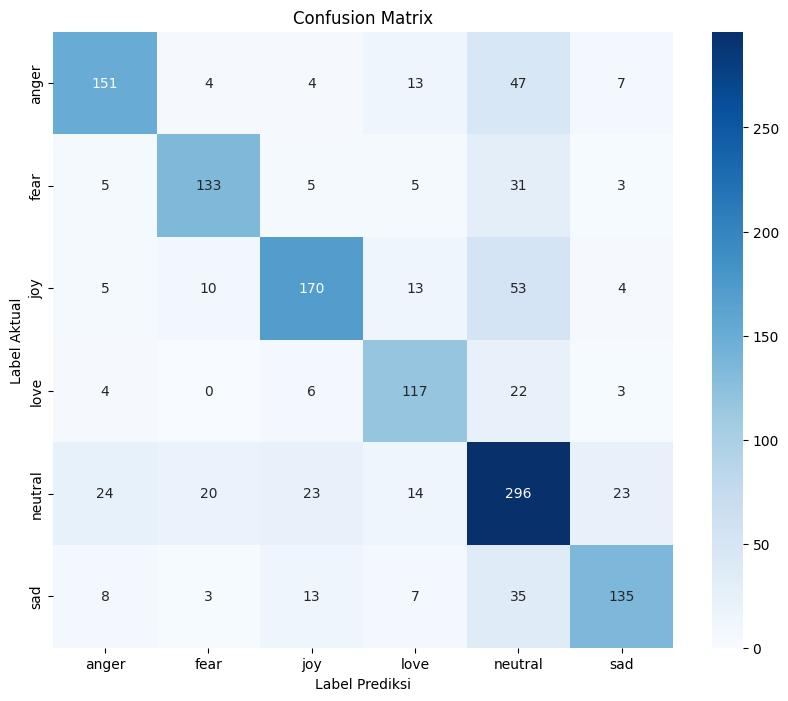

In [14]:
# 1. Split data menggunakan kolom yang SUDAH DIPROSES
X = df['text_processed']
y = df['emotion']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Data telah dibagi. Ukuran data latih: {X_train.shape[0]}, Ukuran data uji: {X_test.shape[0]}")


# 2. Mendefinisikan Pipeline
model_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('lr', LogisticRegression(max_iter=1000, random_state=42))
])


# 3. Training model menggunakan data yang sudah di-preprocess
print("\nMemulai pelatihan Logistic Regression pipeline...")
model_pipeline.fit(X_train, y_train)
print("Pelatihan model selesai.")


# 4. Prediksi pada data test untuk evaluasi
y_pred = model_pipeline.predict(X_test)

# 5. Evaluasi performa
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model_pipeline.classes_, yticklabels=model_pipeline.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Label Aktual')
plt.xlabel('Label Prediksi')
plt.show()

In [15]:
model_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()), # TfidfVectorizer without max_features and ngram_range for initial tuning
    ('lr', LogisticRegression(max_iter=1000, random_state=42))
])

param_grid = {
    'tfidf__max_features': [None, 5000, 10000],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'lr__C': [0.1, 1.0, 10.0],
    'lr__solver': ['liblinear', 'lbfgs'],
}

param_grid = {
    'tfidf__max_features': [None, 5000, 10000],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'lr__C': [0.1, 1.0, 10.0],
    'lr__solver': ['liblinear', 'lbfgs'],
    'lr__penalty': ['l2'] # Start with l2
}

# Add l1 penalty specifically for liblinear
param_grid_l1_liblinear = {
    'tfidf__max_features': [None, 5000, 10000],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'lr__C': [0.1, 1.0, 10.0],
    'lr__solver': ['liblinear'],
    'lr__penalty': ['l1']
}

param_grid = [
  {
    'tfidf__max_features': [None, 5000, 10000],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'lr__C': [0.1, 1.0, 10.0],
    'lr__solver': ['liblinear'],
    'lr__penalty': ['l1', 'l2']
  },
  {
    'tfidf__max_features': [None, 5000, 10000],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'lr__C': [0.1, 1.0, 10.0],
    'lr__solver': ['lbfgs'],
    'lr__penalty': ['l2']
  }
]

grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit the grid search to the training data
print("Starting GridSearchCV for Logistic Regression...")
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("\nBest parameters found:")
print(grid_search.best_params_)

# Print the best cross-validation score
print("\nBest cross-validation accuracy:")
print(grid_search.best_score_)

# Evaluate the best model on the test data
best_lr_model = grid_search.best_estimator_
y_pred_best_lr = best_lr_model.predict(X_test)

print("\nClassification Report for Tuned Logistic Regression:")
print(classification_report(y_test, y_pred_best_lr))


Starting GridSearchCV for Logistic Regression...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best parameters found:
{'lr__C': 10.0, 'lr__penalty': 'l2', 'lr__solver': 'liblinear', 'tfidf__max_features': None, 'tfidf__ngram_range': (1, 2)}

Best cross-validation accuracy:
0.7125716148066829

Classification Report for Tuned Logistic Regression:
              precision    recall  f1-score   support

       anger       0.77      0.73      0.75       226
        fear       0.76      0.79      0.77       182
         joy       0.76      0.68      0.72       255
        love       0.63      0.84      0.72       152
     neutral       0.69      0.66      0.67       400
         sad       0.73      0.72      0.72       201

    accuracy                           0.72      1416
   macro avg       0.72      0.74      0.73      1416
weighted avg       0.72      0.72      0.72      1416




--- Confusion Matrix ---


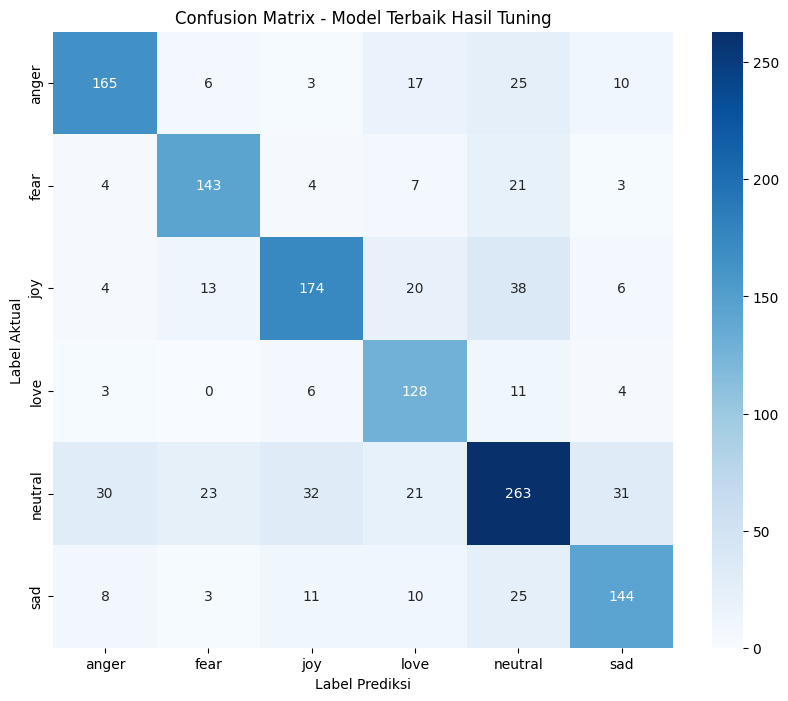

In [16]:
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred_best_lr, labels=best_lr_model.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_lr_model.classes_, yticklabels=best_lr_model.classes_)
plt.title('Confusion Matrix - Model Terbaik Hasil Tuning')
plt.ylabel('Label Aktual')
plt.xlabel('Label Prediksi')
plt.show()

In [17]:
import joblib

# Save the best Logistic Regression model
joblib.dump(grid_search.best_estimator_, 'best_logistic_regression_model.pkl')

['best_logistic_regression_model.pkl']

In [18]:
 print("Model Logistic Regression terbaik telah disimpan sebagai 'best_logistic_regression_model.pkl'")


Model Logistic Regression terbaik telah disimpan sebagai 'best_logistic_regression_model.pkl'


In [19]:
input_text = "aku suka banget" #@param {type:"string"}

input_text_list = [input_text]
predicted_emotion = best_lr_model.predict(input_text_list)

# Tampilkan hasil prediksi
predicted_emotion = best_lr_model.predict(input_text_list)

# Tampilkan hasil prediksi
print(f"\nTeks input: \"{input_text}\"")
print(f"Prediksi emosi oleh model Logistic Regression: {predicted_emotion[0]}")


Teks input: "aku suka banget"
Prediksi emosi oleh model Logistic Regression: love
